In [37]:
import numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [38]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

# คอลัมน์ เป็น Data  ที่ EDA มาแล้ว

- MedInc — รายได้ครัวเรือนเฉลี่ย

- HouseAge — อายุบ้านเฉลี่ย

- AveRooms — จำนวนห้องเฉลี่ยต่อครัวเรือน

- AveBedrms — จำนวนห้องนอนเฉลี่ยต่อครัวเรือน

- Population — ประชากรรวม

- AveOccup — จำนวนคนเฉลี่ยต่อครัวเรือน

- Latitude — ละติจูด

- Longitude — ลองจิจูด

- MedHouseVal — target

In [39]:
data = fetch_california_housing(as_frame=False)
df = pd.DataFrame(data.data, columns=data.feature_names)
display(df.head(10))

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25


# Load Dataset (Regression) & Split ตั้งใจให้ Overfit

In [40]:
data = fetch_california_housing()
X, y = data.data, data.target.astype("float32")  # y: median house value (in 100k USD)

# แบ่งชุดแบบ "เทรนน้อย" เพื่อให้ overfit ง่าย: train=5%, val=15%, test=80%
X_small, X_test, y_small, y_test = train_test_split(X, y, test_size=0.80, random_state=123)
X_train, X_val,  y_train, y_val  = train_test_split(X_small, y_small, test_size=0.75, random_state=123)
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)  # train เล็กมาก

X_train.shape, X_val.shape, X_test.shape


Shapes: (1032, 8) (3096, 8) (16512, 8)


((1032, 8), (3096, 8), (16512, 8))

# StandardScaler

In [41]:
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_val   = x_scaler.transform(X_val)
X_test  = x_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_s = y_scaler.fit_transform(y_train.reshape(-1,1)).ravel()
y_val_s   = y_scaler.transform(y_val.reshape(-1,1)).ravel()
y_test_s  = y_scaler.transform(y_test.reshape(-1,1)).ravel()


# ADD_LABEL_NOISE ให้ Overfit

In [42]:
ADD_LABEL_NOISE = True
if ADD_LABEL_NOISE:
    noise = np.random.normal(0, 0.5, size=y_train_s.shape)  # กำลัง noise
    y_train_s_noisy = y_train_s + noise
else:
    y_train_s_noisy = y_train_s

# โมเดล ANN ใหญ่ ไป

In [43]:
input_dim = X_train.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(1024, activation="relu"),
    layers.Dense(1024, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(1, activation=None),  # linear output for regression
], name="overfit_ann")

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="mse", metrics=["mae"])
model.summary()


Model: "overfit_ann"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 1024)           │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,715,201 (6.54 MB)

 Trainable params: 1,715,201 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
EPOCHS = 60
BATCH_SIZE = 16

history = model.fit(
    X_train, y_train_s_noisy,
    validation_data=(X_val, y_val_s),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
)


Epoch 1/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.9671 - mae: 0.7558 - val_loss: 0.5936 - val_mae: 0.5177
Epoch 2/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7429 - mae: 0.6564 - val_loss: 0.9332 - val_mae: 0.4693
Epoch 3/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5161 - mae: 0.5656 - val_loss: 0.5011 - val_mae: 0.4392
Epoch 4/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4877 - mae: 0.5538 - val_loss: 0.5987 - val_mae: 0.4417
Epoch 5/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5432 - mae: 0.5663 - val_loss: 0.3790 - val_mae: 0.4370
Epoch 6/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5154 - mae: 0.5549 - val_loss: 0.9921 - val_mae: 0.4502
Epoch 7/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4879 - mae: 0.5494 - val_loss: 0.3931 - val_mae: 0.4239
Epoch 8/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4864 - mae: 0.5572 - val_loss: 0.4119 - val_mae: 0.4754
Epoch 9/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5135 -

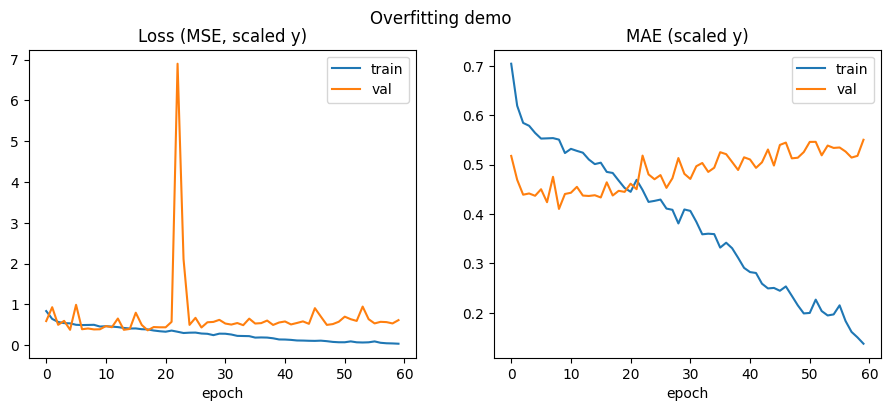

In [45]:
def plot_history(h, title="History"):
    plt.figure(figsize=(11,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(h.history["loss"], label="train")
    plt.plot(h.history["val_loss"], label="val")
    plt.title("Loss (MSE, scaled y)"); plt.xlabel("epoch"); plt.legend()
    # MAE
    plt.subplot(1,2,2)
    plt.plot(h.history["mae"], label="train")
    plt.plot(h.history["val_mae"], label="val")
    plt.title("MAE (scaled y)"); plt.xlabel("epoch"); plt.legend()
    plt.suptitle(title)
    plt.show()

plot_history(history, "Overfitting demo")


# Reset model

In [46]:
drop_rate = 0.30  # ปรับได้ 0.2–0.5

input_dim = X_train.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(drop_rate),

    layers.Dense(1024, activation="relu"),
    layers.Dropout(drop_rate),

    layers.Dense(512, activation="relu"),
    layers.Dropout(drop_rate),

    layers.Dense(256, activation="relu"),
    layers.Dropout(drop_rate * 0.5),  # ใกล้ output ลดลงหน่อย

    layers.Dense(1)  # linear output for regression
], name="overfit_ann_with_dropout")

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="mse", metrics=["mae"])
model.summary()


Model: "overfit_ann_with_dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 1024)           │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,715,201 (6.54 MB)

 Trainable params: 1,715,201 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

# Drop out

In [47]:
EPOCHS = 60
BATCH_SIZE = 16  # batch เล็ก ช่วยให้ fitting แรงขึ้น

history_do = model.fit(
    X_train, y_train_s_noisy,
    validation_data=(X_val, y_val_s),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
)

Epoch 1/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.9789 - mae: 0.7630 - val_loss: 0.7043 - val_mae: 0.5025
Epoch 2/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6591 - mae: 0.6269 - val_loss: 0.8579 - val_mae: 0.4969
Epoch 3/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6164 - mae: 0.6051 - val_loss: 0.6112 - val_mae: 0.4883
Epoch 4/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5875 - mae: 0.5798 - val_loss: 1.4710 - val_mae: 0.4502
Epoch 5/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5631 - mae: 0.5837 - val_loss: 0.5662 - val_mae: 0.4982
Epoch 6/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5976 - mae: 0.6182 - val_loss: 0.4879 - val_mae: 0.4923
Epoch 7/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5814 - mae: 0.5994 - val_loss: 0.8289 - val_mae: 0.4235
Epoch 8/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5304 - mae: 0.5821 - val_loss: 0.6042 - val_mae: 0.4223
Epoch 9/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4915 -

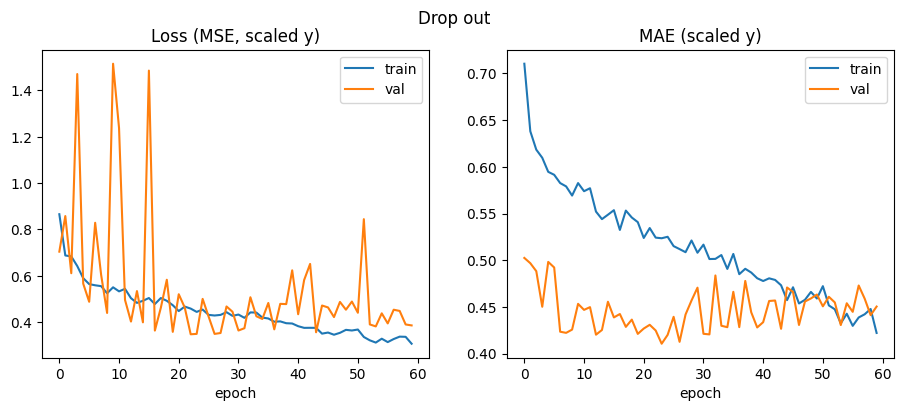

In [48]:
plot_history(history_do, "Drop out")

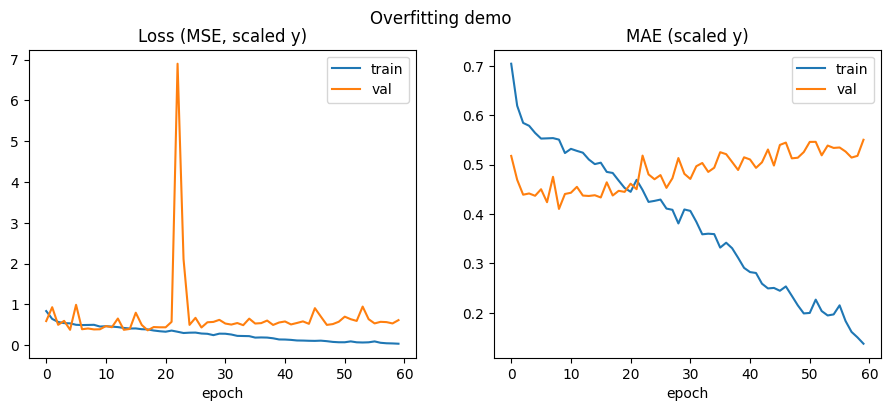

In [49]:
plot_history(history, "Overfitting demo")

# EarlyStopping

In [50]:
input_dim = X_train.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(1024, activation="relu"),
    layers.Dense(1024, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(1, activation=None),  # linear output for regression
], name="overfit_ann")

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="mse", metrics=["mae"])
model.summary()


Model: "overfit_ann"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 1024)           │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,715,201 (6.54 MB)

 Trainable params: 1,715,201 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=12,          # ปรับได้: 8–20 แล้วแต่ความแกว่งของ val
    min_delta=0.0,        # ตั้ง >0 ถ้าอยากให้ "ดีขึ้นอย่างมีนัย"
    restore_best_weights=True,
    verbose=1
)

history_es = model.fit(
    X_train, y_train_s_noisy,         # ใช้ชุด train ที่ใส่ noise ไว้
    validation_data=(X_val, y_val_s),
    epochs=60,                       # ตั้งเยอะไว้ได้ เพราะ ES จะหยุดให้เอง
    batch_size=16,                    # เหมือนที่ใช้เดิม
    callbacks=[es],
    verbose=1
)


Epoch 1/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.9474 - mae: 0.7451 - val_loss: 0.5959 - val_mae: 0.4815
Epoch 2/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6791 - mae: 0.6185 - val_loss: 1.5920 - val_mae: 0.4729
Epoch 3/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5269 - mae: 0.5733 - val_loss: 1.6470 - val_mae: 0.4693
Epoch 4/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5928 - mae: 0.5894 - val_loss: 0.8395 - val_mae: 0.4553
Epoch 5/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4923 - mae: 0.5476 - val_loss: 0.7965 - val_mae: 0.4610
Epoch 6/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5124 - mae: 0.5605 - val_loss: 0.4301 - val_mae: 0.4378
Epoch 7/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4898 - mae: 0.5382 - val_loss: 0.4103 - val_mae: 0.4206
Epoch 8/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4980 - mae: 0.5514 - val_loss: 0.5462 - val_mae: 0.4272
Epoch 9/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4517 - ma

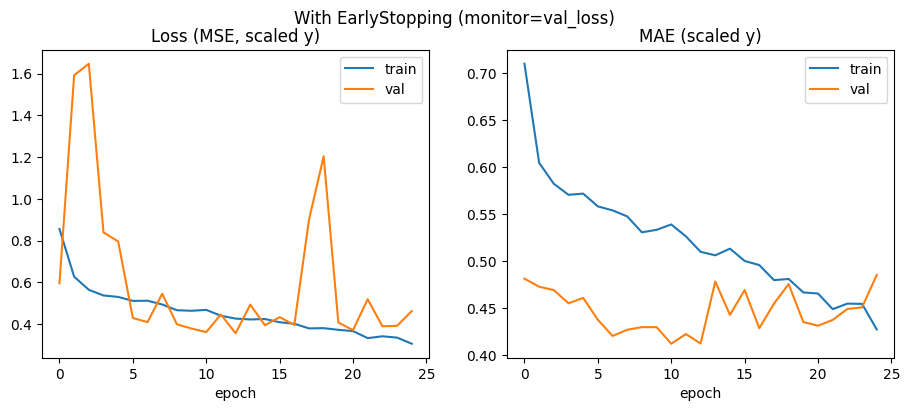

In [52]:
plot_history(history_es, "With EarlyStopping (monitor=val_loss)")

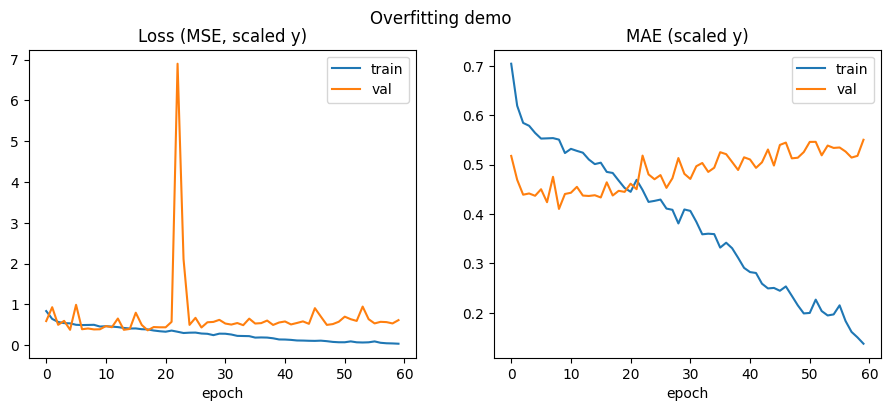

In [53]:
plot_history(history, "Overfitting demo")

# Save model (dropout + EarlyStopping)

In [54]:
model = keras.Sequential([
    layers.Input(shape=(input_dim,)),

    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.3),                 # Dropout to reduce overfitting

    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(512, activation="relu"),
    layers.Dropout(0.25),

    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),

    layers.Dense(1, activation=None),    # linear output for regression
], name="overfit_ann_dropout")

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"]
)

model.summary()

Model: "overfit_ann_dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                │ (None, 1024)           │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,715,201 (6.54 MB)

 Trainable params: 1,715,201 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
EPOCHS = 60
BATCH_SIZE = 16

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath="best_regressor.keras",   # or "best_regressor.h5"
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

earlystop_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,                        # try 5–10; adjust to dataset size
    restore_best_weights=True,         # roll back to the best epoch
    mode="min",
    verbose=1
)


# ------- Train -------
history_all = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs= EPOCHS,
    batch_size= BATCH_SIZE,
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=1
)

# ------- Load best model for evaluation / inference -------
best_model = keras.models.load_model("best_regressor.keras")
test_loss, test_mae = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Best model -> Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


Epoch 1/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.2093 - mae: 1.1166
Epoch 1: val_loss improved from inf to 4.03464, saving model to best_regressor.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 4.1800 - mae: 1.1130 - val_loss: 4.0346 - val_mae: 0.6455
Epoch 2/60
60/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7127 - mae: 0.5817
Epoch 2: val_loss improved from 4.03464 to 1.92637, saving model to best_regressor.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7112 - mae: 0.5821 - val_loss: 1.9264 - val_mae: 0.5576
Epoch 3/60
61/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5771 - mae: 0.5545
Epoch 3: val_loss improved from 1.92637 to 0.94615, saving model to best_regressor.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5772 - mae: 0.5542 - val_loss: 0.9462 - val_mae: 0.4947
Epoch 4/60
55/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4945 - mae: 0.5091
Epoch 4: val_loss improved from 0.94615 to 0.57866, saving model to best_regressor.keras
65/65 ━━━━━━━

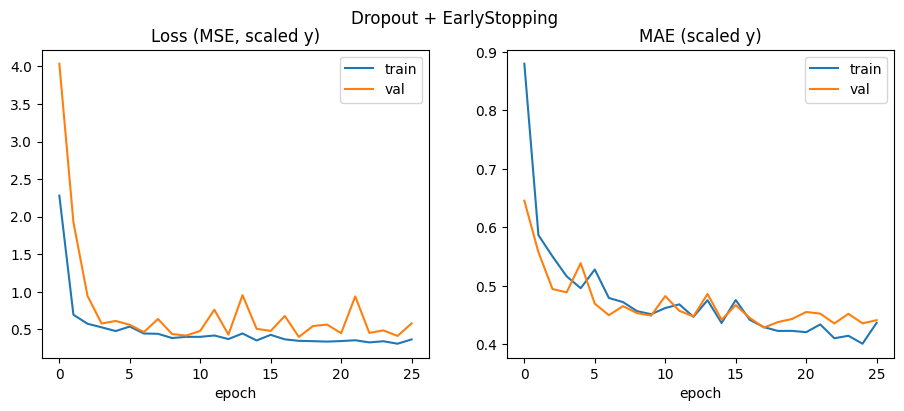

In [56]:
plot_history(history_all, "Dropout + EarlyStopping")

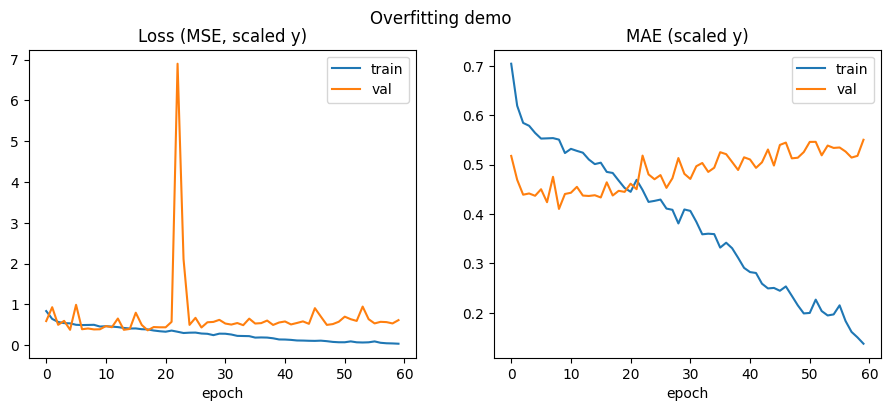

In [58]:
plot_history(history, "Overfitting demo")

# Load model มาใช้งาน

In [57]:
from tensorflow import keras

# โหลด best model ที่เซฟไว้
best_model = keras.models.load_model("best_regressor.keras")

# ใช้ predict
y_pred = best_model.predict(X_test)

# ประเมินผล
loss, mae = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {loss:.4f}, Test MAE: {mae:.4f}")


516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test MSE: 0.3741, Test MAE: 0.4193
